In [1]:
import torch

In [2]:
import os
import sys
# import numpy as np
import pandas as pd

from collections.abc import Callable
from typing import Literal

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
#Helper function
import os
import datetime
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# from utils.log_event import fn_log_event


# verify if the directory exists
def fn_dir_exists(_dir):
    '''
    Args:
    	_dir: path if a directory
     '''

    res = os.path.exists(_dir)

    fn_log_event ('-- Directory "{}" exist : {}'.format(_dir, res), 'debug')

    if not res:

        fn_log_event ('-- Directory "{}" does not exists.'.format(_dir), 'debug')

        sys.exit('-- Directory "{}" does not exists.'.format(_dir))

    return res



def fn_file_exists(_file):
    '''
        verify if the file exists
    '''
    res = os.path.exists(_file)

    fn_log_event ('-- File "{}" exist : {}'.format(_file, res), 'debug')

    if not res:

        fn_log_event ('-- File "{}" does not exists.'.format(_file), 'debug')

        sys.exit('-- File "{}" does not exists.'.format(_file))

    return res


###-----------------------------
### Verify or create a directory
###-----------------------------
def fn_verify_dir(_path : str):
    '''
    Arg:
        path: path to verify the directory
    returns:
        create dir if it does not exists
    '''
    if os.path.exists(_path): # check if the path exists. Maybe a file or a folder

        print(_path, ' exists') # advised the user

    else:

        os.makedirs(_path) # create the path

        print("Created folder : ", _path)

###------------------------------------------------
### Plot Loss Curve using Tensorflow history object
###------------------------------------------------
def fn_plot_tf_hist(hist_df):

    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: loss
            column 1: accuracy
            column 2: val_loss
            column 3: val_accuracy
            While plotting columns are accessed by index
            so that even if the column names are different it will not throw exceptions.
    '''

    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    CMAP = plt.cm.coolwarm

    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]

    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y3].min())
    y_max = max(hist_df[y1].max(), hist_df[y3].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y3].to_numpy()[0] + offset), # location of text
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)

    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y2].min(), hist_df[y4].min())
    y_max = max(hist_df[y2].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y4].to_numpy()[0]-offset), # location of text
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow


    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')

    plt.tight_layout()



###------------------------------
### Plot Loss Curve using pytorch
###------------------------------
def fn_plot_torch_hist(hist_df):

    # instantiate figure
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch
    props = dict(boxstyle='round', facecolor='cyan', alpha=0.5)

    # columns
    x = hist_df.columns[0]
    y1 = hist_df.columns[1]
    y2 = hist_df.columns[2]
    y3 = hist_df.columns[3]
    y4 = hist_df.columns[4]

    # Where was min loss
    best = hist_df[hist_df[y2] == hist_df[y2].min()]
    best = best.drop_duplicates(subset=y2)
    # pick first axis
    ax = axes[0]

    # Plot all losses
    hist_df.plot(x = x, y = [y1, y2], ax = ax)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y2].min())
    y_max = max(hist_df[y1].max(), hist_df[y2].max())
    offset = (y_max-y_min)/10.0

    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y2]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y2].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y2].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()+ offset, best[y2].to_numpy()[0]+offset), # location of text
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best[x].to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel(x.title())
    ax.set_ylabel(y1.title())
    ax.set_title('Errors')
    ax.grid()
    ax.legend(loc = 'upper left') # model legend to upper left

    # pick second axis
    ax = axes[1]

    # Plot accuracies
    hist_df.plot(x = x, y = [y3, y4], ax = ax)

    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y3],
                           hist_df.iloc[-1][y4]) #text to plot

    # calculate offset for arroe
    y_min = min(hist_df[y3].min(), hist_df[y4].min())
    y_max = max(hist_df[y3].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # place a text box in lower middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()- offset, best[y4].to_numpy()[0]-offset), # location of text
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow


    # Draw a vertical line at best value
    ax.axvline(x = best[x].to_numpy(),
               color = 'green',
               linestyle='-.', lw = 3)

    # Labels
    ax.set_xlabel(x.title())
    ax.set_ylabel(y3.title())
    ax.set_title('Accuracies')
    ax.grid();
    ax.legend(loc = 'lower left')

    plt.tight_layout()



###---------------------------------------------------
### Plot count of classes in training and testing sets
###---------------------------------------------------
def fn_plot_labels(tr_ds, ts_ds, class_names = None):

    '''
        Args:
            tr_ds :  Training Dataset
            ts_ds : Testing dataset
        Returns : none
    '''

    # create figure and axes
    fig, axes = plt.subplots(1,2, figsize = (15,5))

    # get names of the classes
    if not class_names:
        tr_class_names = tr_ds.class_names
        ts_class_names = tr_ds.class_names

    # pick first axis
    ax = axes[0]

    # create dict of training labels
    class_counts = {}
    for imgs, lbls in tr_ds:
        for lbl in lbls.numpy():
            class_counts[lbl] = class_counts.get(lbl, 0) +1

    # bar plot
    ax.bar(tr_class_names, [class_counts.get(i, 0) for i in range(len(tr_class_names))],
           align='center',color = 'DarkBlue', alpha = 0.7)

    # add title
    ax.set_title('Training Set')

    # grids make it look good
    ax.grid()


    #pick second image
    ax = axes[1]

    # create dict of training labels
    class_counts = {}
    for imgs, lbls in ts_ds:
        for lbl in lbls.numpy():
            class_counts[lbl] = class_counts.get(lbl, 0) +1

    # bar plot
    ax.bar(ts_class_names, [class_counts.get(i, 0) for i in range(len(ts_class_names))],
           align='center',color = 'orange', alpha = 0.7)

    # add title
    ax.set_title('Test Set')


    # grids make it look good
    ax.grid()

    # fit the subplot(s) in to the figure area
    plt.tight_layout()

    # display all open figures
    plt.show()

def fn_convert_timestamp(tstr):
    '''
        Function to conver string of form "2015-11-12 1444"
    '''

    return datetime.strptime(tstr, "%Y-%m-%d_%H%M")

###----------------------
### Plot confusion matrix
###----------------------
def fn_plot_confusion_matrix(y_true, y_pred, labels):
    '''
    Args:
        y_true: Ground Truth
        y_pred : Predictions
        labels : dictonary
                  {0: 'Goal Keeper',
                  1: 'Defender',
                  2: 'Mid-Fielder',
                  3: 'Forward'}

    '''

    cm  = confusion_matrix(y_true, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels.values())

    fig, ax = plt.subplots(figsize = (6,6))

    disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)
    # Disable the grid
    ax.grid(False)

    plt.show();


In [4]:
inpDir = '../../../input'
outDir = '../output'
modelDir = '../models'
#subDir = 'fifa_2019'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
torch.manual_seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 30 # number of epochs
BATCH_SIZE = 32
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2
# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'medium',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

In [5]:
train_df = pd.read_csv("fashion-mnist_train.csv")
test_df = pd.read_csv("fashion-mnist_test.csv")

train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6,0,0,0,0,0,0,0,5,0,...,0.0,0.0,0.0,30.0,43.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,1,2,0,0,0,0,...,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,3,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
class_labels = {
          0 : 'T-shirt/top',
          1 : 'Trouser',
          2 : 'Pullover',
          3 : 'Dress',
          4 : 'Coat',
          5 : 'Sandal',
          6 : 'Shirt',
          7 : 'Sneaker',
          8 : 'Bag',
          9 : 'Ankle boot'
          }

In [7]:
class FashionDS(Dataset):


  def __init__ (self,
                dataframe: pd.DataFrame,
                device : str = device
                ):
    self.df = dataframe
    self.device = device

    self.labels = self.df['label'].to_numpy()
    X = self.df.drop('label', axis=1).to_numpy()

    self.features = X/255.

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
    #extract features and label from the dataframe row
    features = self.features[index]
    label = self.labels[index]

    #convert to pytorch tensors
    features = torch.tensor(features,
                            dtype=torch.float32,
                            device=self.device)
    label = torch.tensor(label,
                         dtype=torch.int64,
                         device=self.device)

    return features, label


In [8]:
train_ds = FashionDS(train_df)

test_ds = FashionDS(test_df)

In [9]:
train_loader = DataLoader(train_ds,
                          batch_size = BATCH_SIZE,
                          shuffle=True)

test_loader = DataLoader(test_ds,
                          batch_size = BATCH_SIZE,
                          shuffle=True)

In [10]:
images, targets = next(iter(train_loader))

images = images.cpu().numpy()
targets = targets.cpu().numpy()
targets

array([8, 2, 2, 1, 7, 9, 9, 3, 0, 1, 8, 9, 2, 2, 9, 7, 7, 6, 3, 3, 3, 0,
       4, 5, 2, 6, 2, 4, 0, 2, 7, 4])

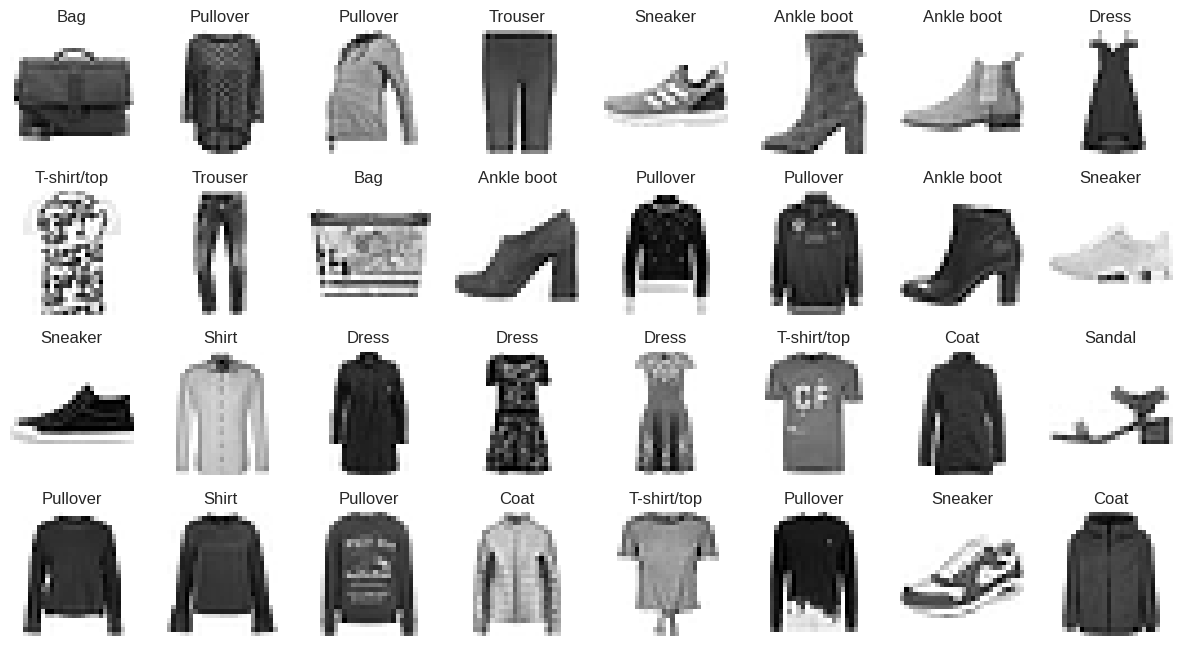

In [11]:
plt.figure(figsize = (15, 8))

for i in range(BATCH_SIZE) :
  plt.subplot(4, 8, i+1)
  plt.imshow(images[i].reshape(28, 28), cmap = plt.cm.binary)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.title(class_labels[targets[i]])

In [12]:
next(iter(train_ds))

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0157, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.2431, 0.2392, 0.0824, 0.1137, 0.0902,
         0.2000, 0.5333, 0.2392, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

In [13]:
input_shape = train_df.shape[1] -1
input_shape

784

In [14]:
class Model(nn.Module):

    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim,16)
        self.activ1 = nn.SiLU()
        self.layer2 = nn.Linear(16, 4)

    def forward(self, x):
        x = self.layer1(x)  #forward pass in layer1
        x = self.activ1(x)
        x = F.softmax(self.layer2(x), dim = 1)
        return x

net = Model(input_dim = input_shape).to(device) # Create model on GPU
print (net)

Model(
  (layer1): Linear(in_features=784, out_features=16, bias=True)
  (activ1): SiLU()
  (layer2): Linear(in_features=16, out_features=4, bias=True)
)


In [15]:
train_loader = DataLoader(train_ds,
                          batch_size = BATCH_SIZE,
                          shuffle=True)

test_loader = DataLoader(test_ds,
                          batch_size = BATCH_SIZE,
                          shuffle=True)

In [16]:
# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # cross entropy loss

loss, tloss = [],[]
acc, tacc = [],[]
n_epoch = []

optimizer = torch.optim.Adam(net.parameters(), lr=ALPHA)

# Train the model for multiple epochs

for epoch in range(EPOCHS):

    # Training loop
    train_loss = 0.0
    train_acc = 0.0

    for i, data in enumerate(train_loader):

        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)

        preds = torch.argmax(outputs, dim = 1)

        batch_loss = loss_fn(outputs, labels)
        batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())

        batch_loss.backward()

        optimizer.step()

        train_loss += batch_loss.item() * inputs.size(0)
        train_acc += batch_acc * inputs.size(0)

    train_loss /= len(train_ds)
    train_acc /= len(train_ds)

    loss.append(train_loss)
    acc.append(train_acc)

    # Testing loop
    test_loss = 0.0
    test_acc = 0.0

    with torch.no_grad():

        for data in test_loader:

            inputs, labels = data

            outputs = net(inputs)

            preds = torch.argmax(outputs, dim = 1)

            batch_loss = loss_fn(outputs, labels)

            batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())

            test_loss += batch_loss.item() * inputs.size(0)
            test_acc += batch_acc* inputs.size(0)

        test_loss /= len(test_ds)
        test_acc /= len(test_ds)

        tloss.append(test_loss)
        tacc.append(test_acc)
    n_epoch.append(epoch)

    if epoch%5 == 0:
        print(f'At epoch {epoch} | Loss - train:{train_loss:.4f}, test:{test_loss:.4f} | Acc - train:{train_acc:.4f}, test:{test_acc:.4f}')

IndexError: Target 9 is out of bounds.

In [ ]:
loss_df = pd.DataFrame({'epoch' : n_epoch, 'loss' : loss, 'test_loss': tloss, 'acc' : acc, 'test_acc': tacc})
loss_df.head()

In [ ]:
fn_plot_torch_hist(loss_df)

In [ ]:
y_train = []
y_pred = []
for i, data in enumerate(train_loader):

    inputs, labels = data

    outputs = net(inputs)

    preds = torch.argmax(outputs, dim = 1)

    y_train.extend(labels.cpu().numpy())

    y_pred.extend(preds.cpu().numpy())

In [ ]:
print(classification_report(y_train,y_pred))

In [ ]:
cm  = confusion_matrix(y_train, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_labels.values())

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)

plt.show();

## Performance on test data

In [ ]:
y_test = []
y_pred = []
for i, data in enumerate(test_loader):

    inputs, labels = data

    outputs = net(inputs)

    preds = torch.argmax(outputs, dim = 1)

    y_test.extend(labels.cpu().numpy())

    y_pred.extend(preds.cpu().numpy())

In [ ]:
print(classification_report(y_test, y_pred ))

In [ ]:
cmt  = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cmt,
                              display_labels=class_labels.values())

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)

plt.show();